##  Mario Bros AI 

### 1) Controlling the mario game usning python

In [1]:
%pip install nes-py
%pip install gym-super-mario-bros==7.3.0
%pip install setuptools==65.5.0 "wheel<0.40.0"
%pip install gym==0.21.0
%pip install stable-baselines3[extra]==1.6.0

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [3]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [2]:
#setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

/home/simonsimple305/.local/lib/python3.10/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-v3`.
  logger.warn(


In [4]:
SIMPLE_MOVEMENT[env.action_space.sample()]

['right', 'A']

In [5]:
done = True
for step in range(10000):
    if done:
        # starts the game
        env.reset()
    # randnom actions
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()
    
env.close()

/home/simonsimple305/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/home/simonsimple305/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/simonsimple305/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/simonsimple305/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was de

KeyboardInterrupt: 

In [5]:
env.step(1)[3]

ResetNeeded: Cannot call env.step() before calling env.reset()

### 2) Preprocessing the game -

In [4]:
#framestacker and grayscaling
from gym.wrappers import  GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [18]:
#1. base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')

#2. simple movement wrapper 
env = JoypadSpace(env, SIMPLE_MOVEMENT)

#3. grayscale
env = GrayScaleObservation(env, keep_dim=True)

#4. vector framstack
env = DummyVecEnv([lambda:env])

#5. stack the frames
env = VecFrameStack(env, 4, channels_order='last') #wil satck 4 frames

In [19]:
state = env.reset()

In [20]:
state, reward, done, info = env.step([env.action_space.sample()])

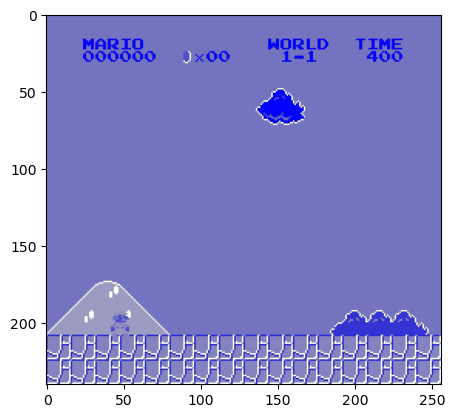

In [22]:
plt.imshow(state[0])

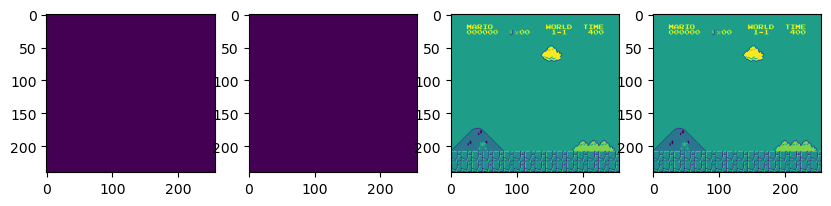

In [23]:
#showing the 4 stacked frames
plt.figure(figsize=(10, 8))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

### 3. Traingin the ai

In [24]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [25]:
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}' , format(self.n_calls))
            self.model.save(model_path)
        return True

In [26]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [27]:
callback = TrainAndLoggingCallback(check_freq=300000, save_path=CHECKPOINT_DIR) # saves the model evry million steps of training

In [28]:
model = PPO('CnnPolicy' , env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.0001, n_steps=1024) #created the model....its aleays harder to get th data

Using cuda device
Wrapping the env in a VecTransposeImage.


##### '''cnn policy is better for image and mlt is better for csv'''

In [29]:
# training the model
model.learn(total_timesteps=1000000,callback=callback)

Logging to ./logs/PPO_5


/home/simonsimple305/.local/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


-----------------------------
| time/              |      |
|    fps             | 30   |
|    iterations      | 1    |
|    time_elapsed    | 33   |
|    total_timesteps | 1024 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 35          |
|    iterations           | 2           |
|    time_elapsed         | 57          |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.028512396 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.93       |
|    explained_variance   | -0.00601    |
|    learning_rate        | 0.0001      |
|    loss                 | 3.3         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00603    |
|    value_loss           | 55.1        |
-----------------------------------------
----------------------------------

/home/simonsimple305/.local/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path 'train/best_model_{}' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


-----------------------------------------
| time/                   |             |
|    fps                  | 56          |
|    iterations           | 293         |
|    time_elapsed         | 5331        |
|    total_timesteps      | 300032      |
| train/                  |             |
|    approx_kl            | 0.017551353 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.16       |
|    explained_variance   | 0.496       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.018      |
|    n_updates            | 2920        |
|    policy_gradient_loss | -0.0232     |
|    value_loss           | 0.163       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 56          |
|    iterations           | 294         |
|    time_elapsed         | 5347        |
|    total_timesteps      | 301056

KeyboardInterrupt: 

In [ ]:
model.save('final-trained-model')

### 4. Testing the model

In [30]:
model = PPO.load('./train/300000.zip')

In [31]:
state = env.reset()

while True:
    action, state = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

/home/simonsimple305/.local/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

: 